In [1]:
%run ../talktools.py

## ML Regression 

You've already seen how to fit $y$ from $\vec x$ when we did Bayesian inference. Now we'll this with different machine learning techniques.

First, let's get some astro data. Say we want to query SDSS for redshifts, and want to build our own predictor of redshift based on photometry. 

[__Astrophysical aside__: As a reminder, for galaxies, photometric redshifts are based on fitting multi-band photometry of a source, whereas spectroscopic redshifts are measured from lines (usually emission) in the spectra.  "Photo-z" measurments are generally less precise than spectroscopic redshifts.  They are often based on broadband photometry and may be affected by dust, stellar populations, metallicity, etc. as well as the object's redshift.  In comparison, spectroscopic redshifts can be precise to several decimal places.]

The SDSS table [`SpecPhoto`](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx?cmd=description+SpecPhoto+V#&&history=description+SpecPhoto+V) is the joined `Spectro` and `Photo` objects that have the clean spectra. That is, it's well-detected sources with spectroscopic redshifts. We'll join this with
the photometric redshifts of these sources so we can see how well our values line with those derived from the
SDSS team's estimates.

### Get some astro data 

In [124]:
%matplotlib inline

import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import corner 
sns.set()
sns.set_context("poster")

In [148]:
query = """
SELECT TOP 5000 SpecPhoto.objID, SpecPhoto.z as specz, SpecPhoto.zErr as speczerr,
       Photoz.z as photoz, Photoz.zErr as photozerr,
       dered_r, dered_u - dered_g as ug_color, dered_g - dered_r as gr_color, dered_r - dered_i as ri_color, 
       dered_i - dered_z as iz_color,  
       modelMagErr_u, modelMagErr_g, modelMagErr_r, 
       modelMagErr_i, modelMagErr_z,
       fiberMag_r, fiberMag_u - fiberMag_g as fiber_ug, fiberMag_g - fiberMag_r as fiber_gr, 
       fiberMag_r - fiberMag_i as fiber_ri, fiberMag_i - fiberMag_z as fiber_iz
from SpecPhoto
JOIN Photoz on Photoz.objid = SpecPhoto.objid
WHERE
  class = 'GALAXY' and
  SpecPhoto.z > 0.2 and
  SpecPhoto.zErr < 0.1 and
  abs(Photoz.z  - SpecPhoto.z) < 1 and
  SpecPhoto.zErr > 0.0
"""

In [149]:
sdss_sql_URL = "https://skyserver.sdss.org/dr12/en/tools/search/x_results.aspx"
r = requests.get(sdss_sql_URL, params = {'cmd': query, 'format': "csv",
                                         "searchtool": "SQL", "TaskName": "Skyserver.Search.SQL",
                                         "syntax": "NoSyntax", "ReturnHtml": "false",
                                         "TableName": ""})

In [150]:
df = pd.read_csv(io.StringIO(r.text), delimiter=",", comment="#")
df.head()

,objID,specz,speczerr,photoz,photozerr,dered_r,ug_color,gr_color,ri_color,iz_color,modelMagErr_u,modelMagErr_g,modelMagErr_r,modelMagErr_i,modelMagErr_z,fiberMag_r,fiber_ug,fiber_gr,fiber_ri,fiber_iz
0,1237648703514280021,0.250500,0.000046,0.271768,0.017291,17.51684,2.194141,1.590708,0.539917,0.274674,0.253255,0.018430,0.007622,0.006595,0.015727,18.93658,2.081184,1.495203,0.558422,0.356077
1,1237648704585990170,0.268236,0.000052,0.223113,0.016924,17.63522,1.805365,1.316517,0.516357,0.268726,0.162743,0.016043,0.008407,0.007789,0.021769,19.12700,1.757587,1.342310,0.550194,0.351284
2,1237648721245831534,0.355940,0.000091,0.343870,0.028058,18.17893,3.039919,1.696634,0.620796,0.417831,1.131744,0.037485,0.013517,0.011868,0.030165,19.84321,2.237637,1.760029,0.648901,0.418909
3,1237651736314183777,0.235981,0.000063,0.201577,0.012582,17.47912,3.005768,1.286972,0.471277,0.332382,0.892574,0.025354,0.012622,0.012754,0.037358,19.60737,2.080759,1.321678,0.511873,0.351336
4,1237657191981187370,0.212389,0.000032,0.235098,0.017193,18.12329,1.613901,1.358730,0.499412,0.312872,0.146416,0.018746,0.009341,0.009055,0.019835,19.09290,1.339525,1.388546,0.520674,0.321245


In [151]:
df.describe()

,objID,specz,speczerr,photoz,photozerr,dered_r,ug_color,gr_color,ri_color,iz_color,modelMagErr_u,modelMagErr_g,modelMagErr_r,modelMagErr_i,modelMagErr_z,fiberMag_r,fiber_ug,fiber_gr,fiber_ri,fiber_iz
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.237656e+18,0.374967,0.000114,0.368514,0.029481,18.887149,2.147500,1.538904,0.669558,0.369846,0.756732,0.077077,0.027548,0.020719,0.051652,20.103886,1.702510,1.549636,0.696040,0.404151
std,6.414807e+12,0.131336,0.001215,0.128031,0.019586,1.127473,1.197173,0.365096,0.256751,0.166782,0.616760,0.093118,0.038729,0.036804,0.057158,0.931061,0.778603,0.321339,0.213841,0.110160
min,1.237646e+18,0.200017,0.000005,0.025668,0.007117,16.294630,-2.653950,-0.253414,-4.940811,-1.831858,0.020515,0.006420,0.004240,0.003957,0.008067,18.020080,-1.332376,-0.298803,-1.316587,-0.862431
25%,1.237651e+18,0.263565,0.000050,0.262968,0.018100,17.989885,1.382463,1.379402,0.531816,0.320779,0.283053,0.023707,0.010846,0.009997,0.024559,19.379665,1.189283,1.406701,0.558741,0.351864
50%,1.237655e+18,0.355072,0.000086,0.355771,0.024358,18.789250,2.003989,1.612046,0.616929,0.366125,0.579252,0.050018,0.017941,0.015263,0.038285,20.007325,1.762563,1.626043,0.641869,0.396242
75%,1.237661e+18,0.462558,0.000128,0.459800,0.033803,19.577585,2.693518,1.753140,0.786258,0.423152,1.081557,0.091532,0.031491,0.024451,0.061905,20.690528,2.185556,1.766635,0.806153,0.456363
max,1.237679e+18,1.071562,0.085897,0.964970,0.233327,24.246430,7.123680,5.101282,4.852097,5.587070,4.465066,1.538895,1.736818,1.597887,2.258772,23.217840,4.775087,3.063126,1.593012,1.075277


In [152]:
df.to_csv("galspec.csv", index=False)

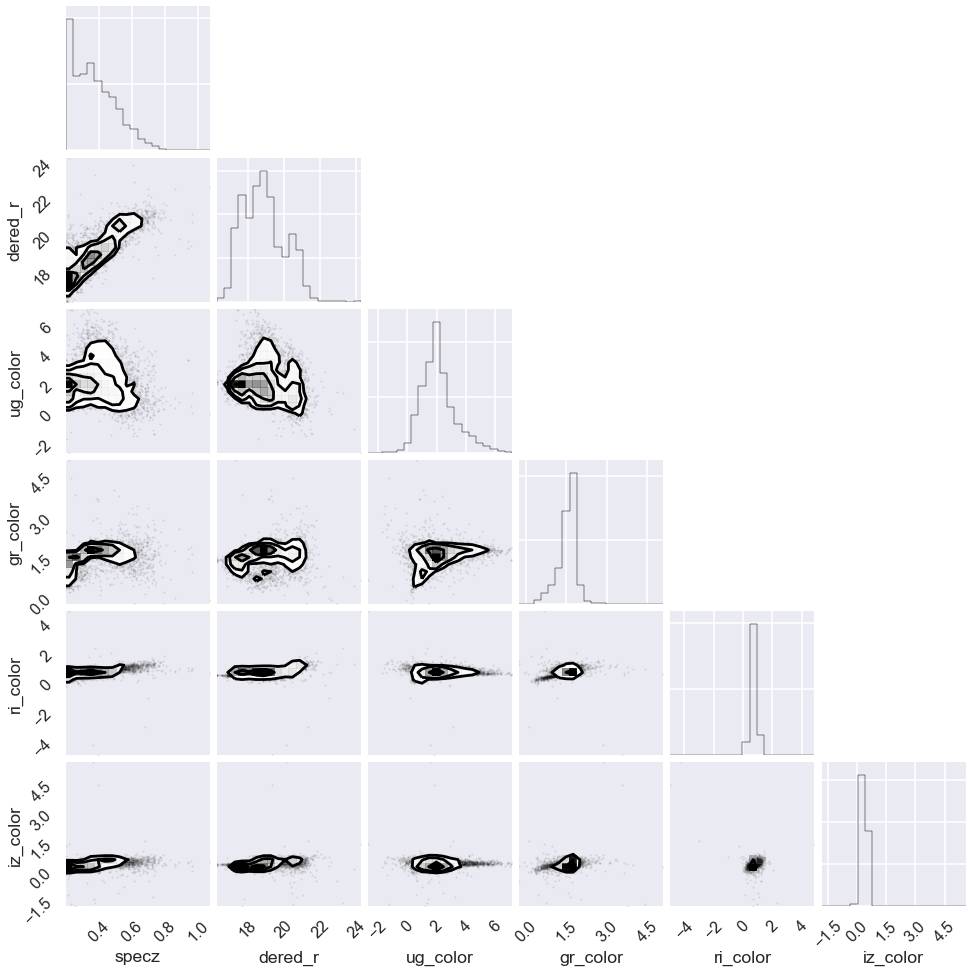

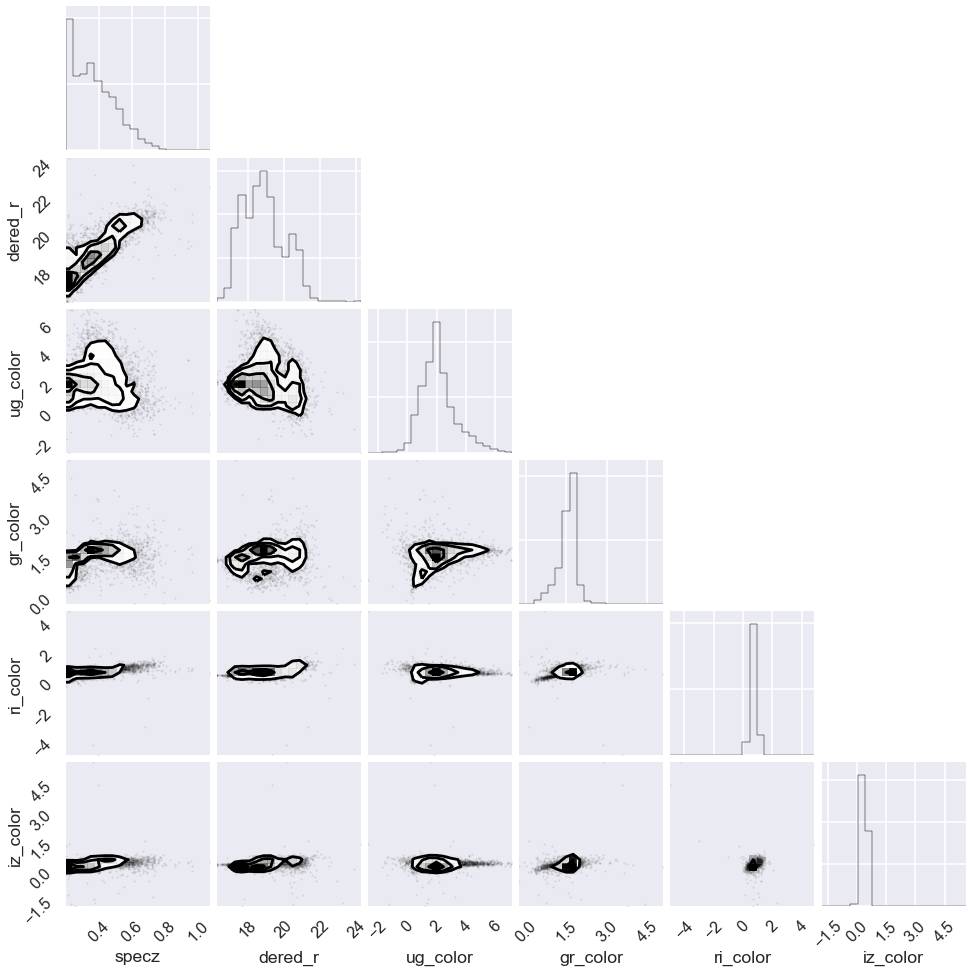

In [153]:
corner.corner(df[['specz', 'dered_r', 'ug_color', 'gr_color', 'ri_color', 'iz_color']])

In [154]:
X = df[['dered_r', 'ug_color', 'gr_color', 'ri_color', 'iz_color', 'modelMagErr_u',
       'modelMagErr_g', 'modelMagErr_r', 'modelMagErr_i', 'modelMagErr_z',
       'fiberMag_r', 'fiber_ug', 'fiber_gr', 'fiber_ri', 'fiber_iz']]
y = df[["specz"]]

## Let's do some regression - to get `specz`

In [155]:
print("feature vector shape=", X.shape)
print("class shape=", y.shape)

feature vector shape= (5000, 15)
class shape= (5000, 1)


We want to split the data to help us learn a model on $\vec X$ and then test to see how well our model does on held-out data. The `sklearn` [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) will do the work for us to split the data.

In [156]:
from sklearn.model_selection import train_test_split

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

In [158]:
X_train.shape, y_train.shape

((3350, 15), (3350, 1))

In [159]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

In [160]:
# fit the model
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [161]:
# now do the prediction
y_lr_pred = clf.predict(X_test)

# how well did we do?
from sklearn.metrics import mean_squared_error
mse = np.sqrt(mean_squared_error(y_test, y_lr_pred)) ; print("MSE",mse)

MSE 0.056304684774900166


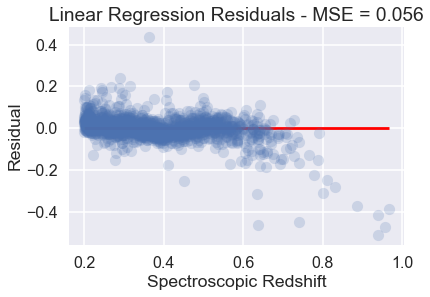

In [164]:
plt.plot(y_test,y_lr_pred - y_test,'o',alpha=0.2)

plt.title("Linear Regression Residuals - MSE = %.3f" % mse)

plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(y_test),max(y_test),color="red")

In [166]:
# here's the MSE guessing the AVERAGE value
print("naive mse", ((1./len(y_train)*(y_train - y_train.mean())**2).sum()))

naive mse 0.017139842556575312


## k-nearest neighbors

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/2000px-KnnClassification.svg.png" width="50%">

For each test point, $\vec x_i$ find the $k$-nearest 
instances in the training data


"The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as non-generalizing machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree.)."

http://scikit-learn.org/stable/modules/neighbors.html

In [167]:
from sklearn import neighbors
from sklearn import preprocessing

pt = preprocessing.PowerTransformer()  # this serves to rescale (non-linearly) the data so that it is roughly Gaussian
X_train_scaled = pt.fit_transform(X_train)
X_test_scaled = pt.transform(X_test)

In [168]:
clf1 = neighbors.KNeighborsRegressor(10)
clf1.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

MSE (KNN) 0.0027577464937185857


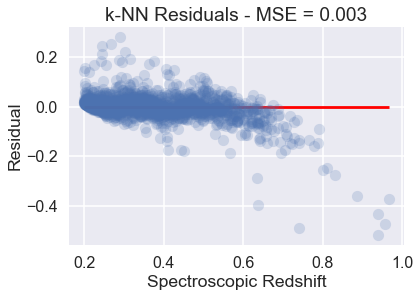

In [169]:
y_knn_pred = clf1.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_knn_pred) ; print("MSE (KNN)", mse)
plt.plot(y_test, y_knn_pred - y_test,'o',alpha=0.2)
plt.title("k-NN Residuals - MSE = %.3f" % mse)
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Residual")
plt.hlines(0,min(y_test),max(y_test),color="red")

## Error Estimation & Model Selection

**Q**: How will our model perform on future data?

So far, we’ve split the data, using one set to train the model and the other to test its performance

This train-test strategy avoids over-fitting to the sample on hand, but wastes data & can produce poor error estimates.

cf http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

### model selection: cross-validation


- *K-fold CV* - randomly split the training data into K folds.  For each $k=1,...,K$, train model only on the data not in fold $k$ & predict for data in fold $k$.  Compute performance metric over CV predictions.

- *Leave-one-out (LOO) CV* - K-fold CV with  K = number of training points.

<img src="https://www.evernote.com/l/AUWvg9caKz1OO7opS2Ji3Z7OwOFkLCrg2WsB/image.png">

<img src="http://i.stack.imgur.com/YWgro.gif">

In [132]:
from sklearn import model_selection

In [136]:
model_selection.?

In [170]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

from sklearn.model_selection import cross_val_score

def print_cv_score_summary(model, xx, yy, cv):
    scores = cross_val_score(model, xx, yy, cv=cv, n_jobs=1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [172]:
# Returns the coefficient of determination R^2 of the prediction.
print_cv_score_summary(clf, X.values, y.values,
                       cv=model_selection.KFold(20, shuffle=True, random_state = 42))

mean: 0.846768, stdev: 0.042324
